# Genetic programming: symbolic regresion

In [3]:
%load_ext autoreload
%autoreload 2
import gp
import plotting as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import product
from random import seed
from math import sin, cos, pi, exp, sqrt, log
import time

In [4]:
# set of problems
problems = ({'func' : lambda x: exp(abs(x))*sin(x), 'interval' : np.array(list(product(np.arange(-3,3.1,0.1)))), 'name' : 'e^|x|*sin(x)'},)
def generate_dataset(inputs, func):
    outputs = np.zeros_like(inputs[:, 0])
    for i, t in enumerate(inputs):
        outputs[i] = func(*t)
    return np.column_stack([inputs, np.vstack(outputs)])


In [5]:
# gp parameters
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def safe_div(x, y): return x / y if y != 0 else x
def safe_log(x): return log(max(1e-10, abs(x)))
def safe_exp(x): return exp(min(30, x))

BINARY_FUNCTIONS = (add, sub, mul, safe_div)
UNARY_FUNCTIONS = (abs, sin, cos, safe_exp, safe_log)
FUNC_NAMES = {add : '+', sub : '-', mul : '*', safe_div : '/', sin : 'sin', cos : 'cos', abs : 'abs', safe_exp : 'e^', safe_log : 'log'}
INPUTS = ['x']
TERMINALS = [-1, 0, 1] + INPUTS


gp.Parameters.gp_rules = {
    'binary_functions' : BINARY_FUNCTIONS,
    'unary_functions' :  UNARY_FUNCTIONS,
    'func_names' :       FUNC_NAMES,
    'terminals' :        TERMINALS,
    'inputs' :           INPUTS,
    'pop_size' :         128, # population size
    'min_depth' :        2, # minimal initial random tree depth
    'max_depth' :        4, # maximal initial random tree depth
    'generations' :      np.inf, # maximal number of generations to run evolution
    'tournament_size' :  3, # size of tournament for tournament selection
    'xo_rate' :          0.5, # crossover rate
    'prob_mutation' :    0.1, # per-node mutation probability
    'epsilon' :          0.1, # epsilon used to compute hit rate
    'evaluations_limit' : 5e5
}

In [6]:
runs = 5

## Using fitness predictor

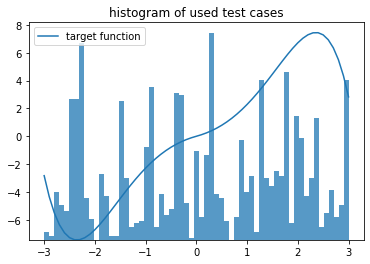

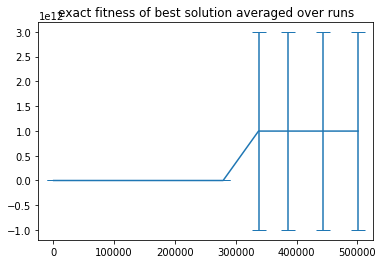

execution time: 79.25139093399048
best solution had fitness 0.8428718775282993


In [7]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
start = time.time()

for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    fp_manager = gp.SLFitnessPredictorManager(x, d.shape[0])
    
    x_values = []
    used_predictors = []
    fitnesses = []
    best_run_fitness = np.inf
    
    for i in range(runs):
        res = x.run_evolution(fp_manager=fp_manager, verbose=False)
        best_run_fitness = min(res['best_of_run_exact_fitness'], best_run_fitness)
            
        x_values.append(res['test_cases_evaluations'])
        used_predictors.append(res['used_predictors'])
        fitnesses.append(res['best_of_run_fitnesses'])
        
    # select widest range
    x_values = x_values[np.argmax([len(v) for v in x_values])]
    
    # fill shorter runs with last values (in case some run converged or something...)
    for i in range(len(fitnesses)):
        while len(used_predictors[i]) < len(x_values): used_predictors[i] = np.append(used_predictors[i], used_predictors[-1])
        while len(fitnesses[i]) < len(x_values): fitnesses[i] = np.append(fitnesses[i], fitnesses[i][-1])
    used_predictors = np.concatenate(used_predictors).flatten()
    used_predictors = d[:, 0][used_predictors]
    fitnesses = np.vstack(fitnesses)
    
    #plot histogram
    vals, bins = np.histogram(used_predictors.flatten(), bins=d.shape[0])
    # make bins same size as graph of the function
    vals = vals * ((max(d[:, 1]) - min(d[:, 1])) / max(vals))
    plt.bar(bins[:-1], vals, bottom=min(d[:, 1]), align='edge', alpha=0.75, width=(d[-1, 0]-d[0, 0]) / len(vals))
    plt.plot(d[:, 0], d[:, 1], label='target function')
    plt.title('histogram of used test cases')
    plt.legend()
    plt.show()
    
    #plot fitness
    avg_fitnesses = np.mean(fitnesses, axis=0)
    errors = np.std(fitnesses, axis=0)
    idxs = np.linspace(0, len(x_values)-1, 10, dtype=np.int32)
    plt.errorbar(x_values[idxs], avg_fitnesses[idxs], yerr=errors[idxs], capsize=7)
    plt.title('exact fitness of best solution averaged over runs')
    plt.show()
          
end = time.time()
print(f'execution time: {end - start}')
print(f'best solution had fitness {best_run_fitness}')

## Using all test cases

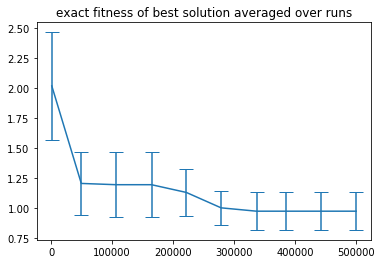

execution time: 73.33042669296265
best solution had fitness 0.8199507197552032


In [8]:
start = time.time()

for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    fp_manager = gp.SLFitnessPredictorManager(x, d.shape[0])
    
    x_values = []
    fitnesses = []
    best_run_fitness = np.inf
    
    for i in range(runs):
        res = x.run_evolution(fp_manager=fp_manager, verbose=False)
        x_values.append(res['test_cases_evaluations'])
        fitnesses.append(res['best_of_run_fitnesses'])
        best_run_fitness = min(res['best_of_run_exact_fitness'], best_run_fitness)
        
    # select widest range
    x_values = x_values[np.argmax([len(v) for v in x_values])]
    
    # fill shorter runs with last values (in case some run converged or something...)
    for i in range(len(fitnesses)):
        while len(fitnesses[i]) < len(x_values): fitnesses[i] = np.append(fitnesses[i], fitnesses[i][-1])
    
    fitnesses = np.vstack(fitnesses)
    
    #plot fitness
    avg_fitnesses = np.mean(fitnesses, axis=0)
    errors = np.std(fitnesses, axis=0)
    idxs = np.linspace(0, len(x_values)-1, 10, dtype=np.int32)
    plt.errorbar(x_values[idxs], avg_fitnesses[idxs], yerr=errors[idxs], capsize=7)
    plt.title('exact fitness of best solution averaged over runs')
    plt.show()
          
end = time.time()
print(f'execution time: {end - start}')
print(f'best solution had fitness {best_run_fitness}')